# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated every day starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated numbers of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [1]:
import requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime
import scipy.stats as stats
from time import time

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima
from pmdarima.arima import ndiffs

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
import tensorflow as tf

from borrowed_functions import lag_df, ts_predict, plot_ts, hms_string

# custom functions written for this project
from functions import (
    split_data, 
    plot_forecast, 
    arima_predict, 
    evaluate_model, 
    plot_trans_train,
    cross_validation,
    regressor_predict,
    analyze_regressor,
    reshape_data,
    train_lstm,
    lstm_predict,
    get_inversed_data,
    lstm_results,
    lstm_cross_validation
)

SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option("display.max_rows", 6)
plt.style.use("ggplot")
plt.rcParams.update(
    {
        "font.size": 18,
        #                      'axes.labelweight': 'bold',
        "figure.figsize": (18, 8),
    }
)

Using TensorFlow backend.


In [2]:
# params = {'function': 'FX_DAILY',
#           'from_symbol': 'CAD',
#           'to_symbol': 'USD',
#           'outputsize': 'full',
#           'apikey': 'EE9EK3VEPFIU7M6N'}

# url = "https://www.alphavantage.co/query"
# response = requests.get(url, params)

# json_data = response.json()

# # Check if the request was successful, if not raise an
# # exception
# if 'Error Message' in list(json_data.keys()):
#     raise Exception("Request failed.")

# # Create the pandas dataframe (see: pd.read_json() )
# data = pd.DataFrame(json_data[list(json_data.keys())[1]]).\
# transpose().apply(pd.to_numeric).reset_index()

# data.columns = ['date', 'open', 'high', 'low', 'close']
# data.date = pd.to_datetime(data.date)

# data.head()

In [3]:
# sub_data =\
# pd.merge(
#     pd.DataFrame(
#         pd.date_range(
#             start='2018-01-01',
#             end='2019-12-31'),
#         columns=['date']),
#     data, how='left')

In [4]:
# sub_data.to_csv('../data/raw_data/cad_to_usd_2018-2019.csv', index=False)
cad_to_usd = pd.read_csv("../data/raw_data/cad_to_usd_2018-2019.csv")

## 3. Explore the dataset

## 4. Initial thoughts


## 5. Wrangling

In [5]:
# data imputation with last observation carried over
cad_to_usd = cad_to_usd.fillna(method="ffill").dropna()
# cad_to_usd = cad_to_usd.set_index('date')
cad_to_usd.head()

,date,open,high,low,close
0,2018-01-01,0.7945,0.7973,0.7943,0.7964
1,2018-01-02,0.7962,0.7998,0.7957,0.7986
2,2018-01-03,0.7986,0.7998,0.7961,0.7972
3,2018-01-04,0.7969,0.8008,0.7959,0.8004
4,2018-01-05,0.8000,0.8090,0.7987,0.8059


Split data into train, valid and test datasets

In [6]:
train, valid, test, train_valid = split_data(cad_to_usd[["close"]], 30)

print(f"The shape of train is {train.shape}")
print(f"The shape of valid is {valid.shape}")
print(f"The shape of test is {test.shape}")

# train.to_csv('../data/clean_data/train.csv')
# valid.to_csv('../data/clean_data/valid.csv')
# test.to_csv('../data/clean_data/test.csv')

The shape of train is (670, 1)
The shape of valid is (30, 1)
The shape of test is (30, 1)


In [7]:
# train = pd.read_csv("../data/clean_data/train.csv", index_col=0)
# valid = pd.read_csv("../data/clean_data/valid.csv", index_col=0)
# test = pd.read_csv("../data/clean_data/test.csv", index_col=0)

## 6. Research questions

What are the CAD to USD exchange rates in 30 days given previous exchange rate?

## 7. Data Analysis & Visualizations

Visualize the time series data

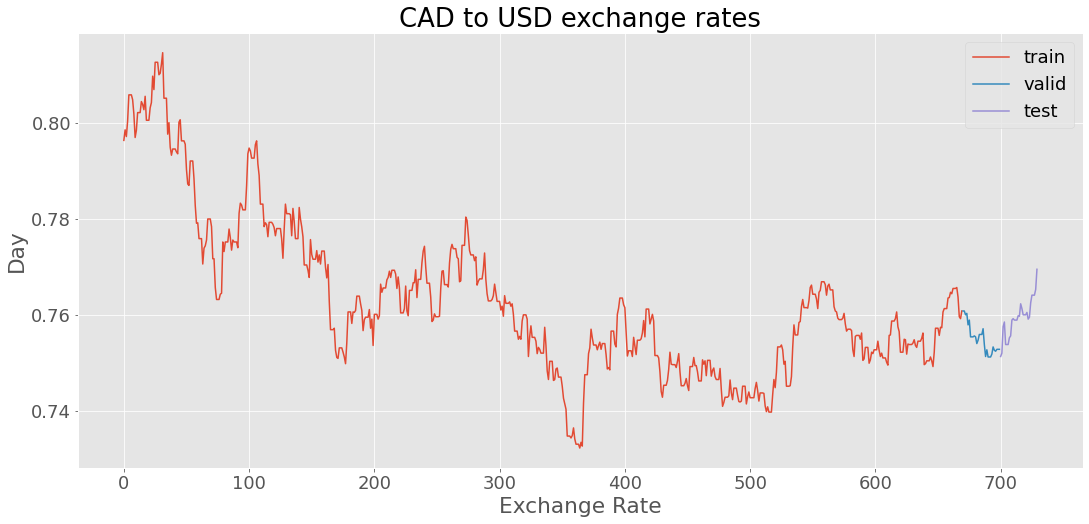

In [8]:
plt.plot(train.close, label="train")
plt.plot(valid.close, label="valid")
plt.plot(test.close, label="test")
plt.legend(loc="upper right", fontsize=18)
plt.title(f"CAD to USD exchange rates")
plt.xlabel('Exchange Rate')
plt.ylabel('Day')
plt.savefig(f'../results/data_visual.png', bbox_inches='tight')

Decompose the process:

$y_t = T_t + S_t + R_t$

where $y_t$ is the data, $T_t$ is the trend-cycle component, $S_t$ is the seasonal component, and $R_t$ is the remainder component, all at period $t$. 

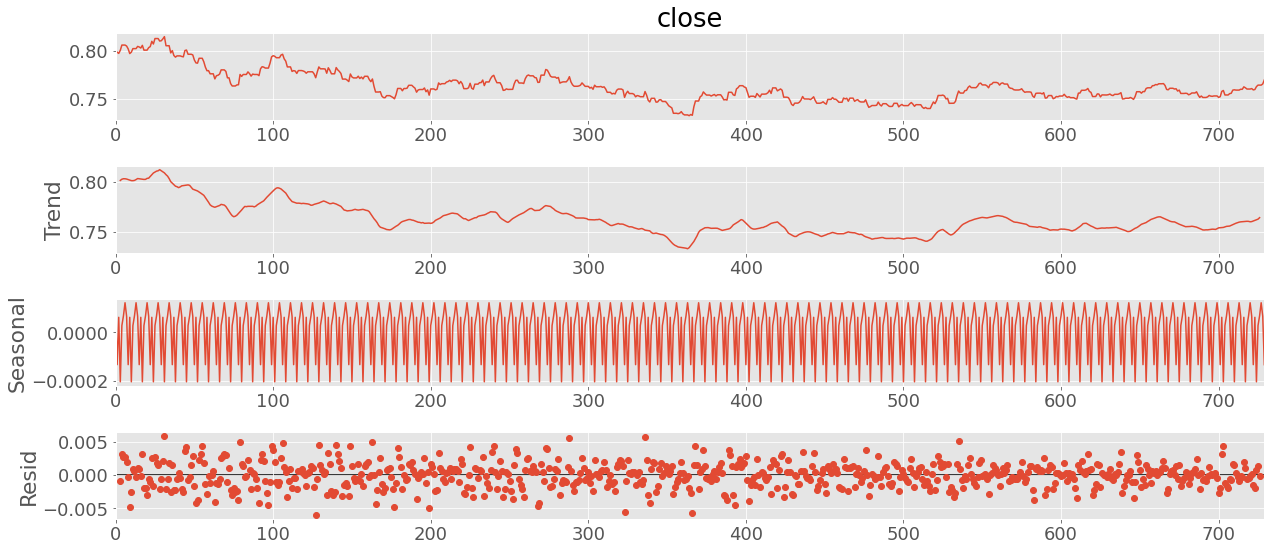

In [9]:
rcParams["figure.figsize"] = 18, 8
decomposition = seasonal_decompose(cad_to_usd.close, period=7, model="additive")
fig = decomposition.plot()

Based on the decomposition results, the process is not stationary.

### 1. ARIMA 

#### 1.1 ARIMA by hand


In [10]:
result = adfuller(train.close)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -2.531258
p-value: 0.108053


The null hypothesis of the ADF test is that the time series is non-stationary. The p-value is bigger than the significance level (0.05). I would try to difference the series.

Find the order of the AR term (p), the order of differencing (d) and the order of the MA term (q) in ARIMA model.


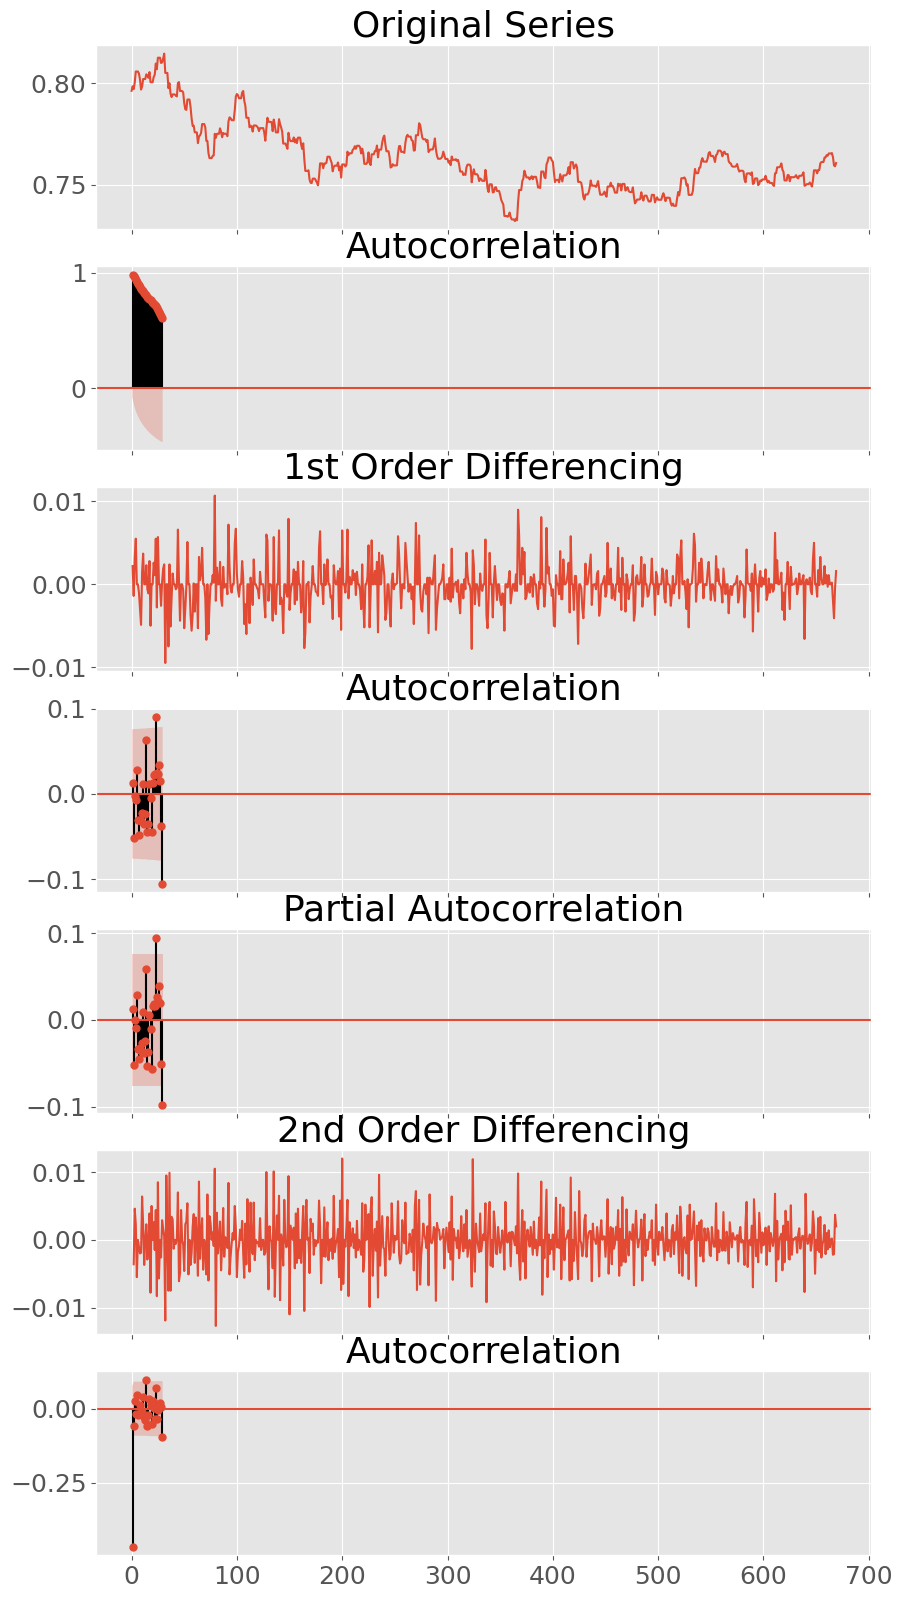

In [11]:
# ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

fig, axes = plt.subplots(7, sharex=True, figsize=(10, 20), dpi=100)

# original series
axes[0].plot(train.close)
axes[0].set_title("Original Series")
plot_acf(train.close, ax=axes[1], zero=False)

# 1st Differencing
axes[2].plot(train.close.diff())
axes[2].set_title("1st Order Differencing")
plot_acf(train.close.diff().dropna(), ax=axes[3], zero=False)
plot_pacf(train.close.diff().dropna(), ax=axes[4], zero=False)

# 2nd Differencing
axes[5].plot(train.close.diff().diff())
axes[5].set_title("2nd Order Differencing")
plot_acf(train.close.diff().diff().dropna(), ax=axes[6], zero=False)

plt.show()

The ACF plot of the first order differencing decreases to zero quickly, so I would choose d as 1 and q as 1.

The PACF plot of the first order differencing decreases to zero quickly, so I would choose p as 1.


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  669
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3052.802
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 29 Jun 2020   AIC                          -6097.604
Time:                        02:34:44   BIC                          -6079.581
Sample:                             1   HQIC                         -6090.623
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.314e-05   9.93e-05     -0.535      0.592      -0.000       0.000
ar.L1.D.close    -0.7168      0.276     -2.601      0.009      -1.257      -0.177
ma.L1.D.close     0.7473      0.262     

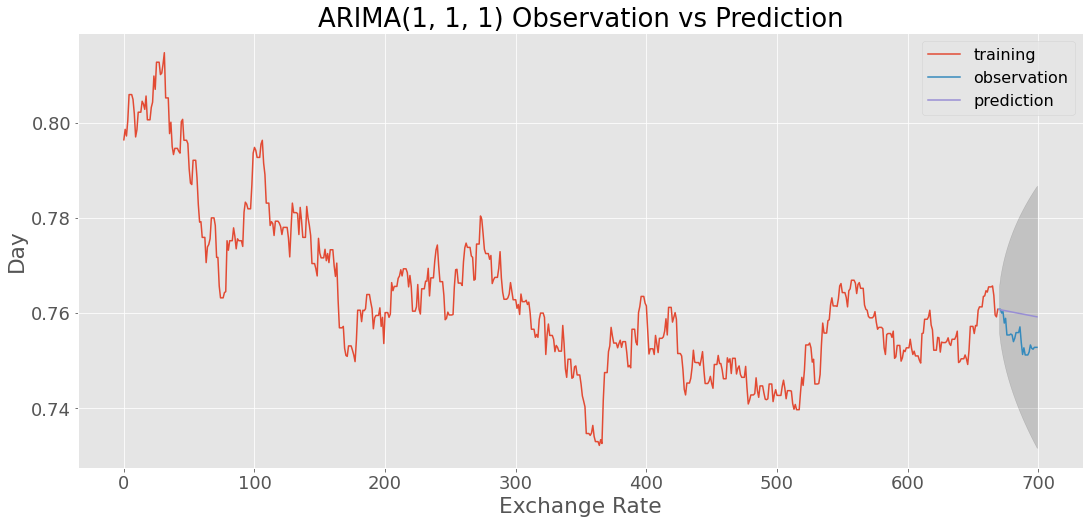

In [12]:
model_1 = ARIMA(train.close, order=(1, 1, 1))
model_1_fit = model_1.fit(disp=-1)
print(model_1_fit.summary())
fc_series, lower_series, upper_series = arima_predict(
    model_1_fit, valid.size, valid.index, auto=False
)
plot_forecast(train, valid, fc_series, "ARIMA(1, 1, 1)", lower_series, upper_series)
scores_1 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(1, 1, 1)")

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  670
Model:                     ARMA(2, 0)   Log Likelihood                3056.421
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 29 Jun 2020   AIC                          -6104.841
Time:                        02:34:44   BIC                          -6086.812
Sample:                             0   HQIC                         -6097.858
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7663      0.008     95.061      0.000       0.750       0.782
ar.L1.close     1.0085      0.039     26.124      0.000       0.933       1.084
ar.L2.close    -0.0194      0.039     -0.501    

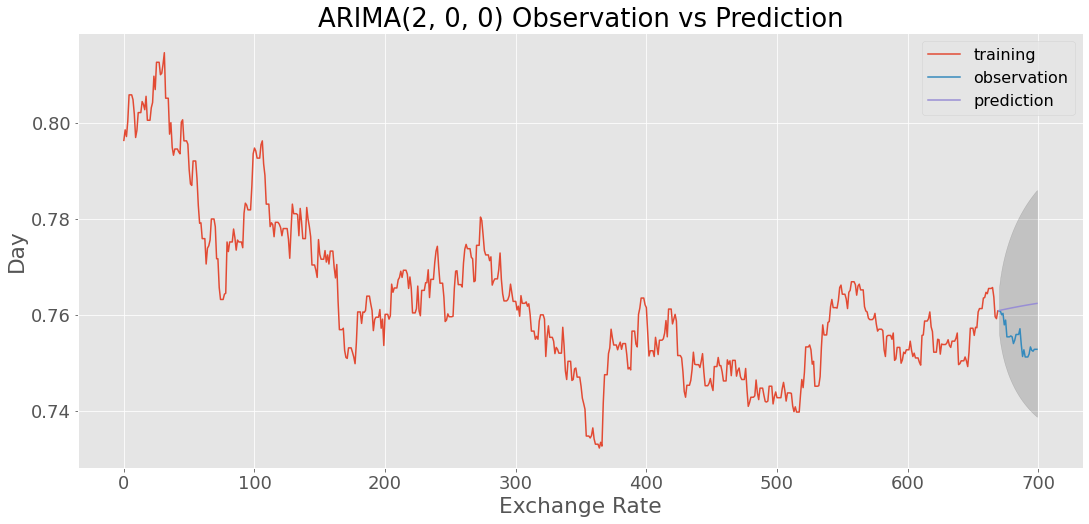

In [13]:
model_2 = ARIMA(train.close, order=(2, 0, 0))
model_2_fit = model_2.fit(disp=-1)
print(model_2_fit.summary())
fc_series, lower_series, upper_series = arima_predict(
    model_2_fit, valid.size, valid.index, auto=False
)
plot_forecast(train, valid, fc_series, "ARIMA(2, 0, 0)", lower_series, upper_series)
scores_2 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(2, 0, 0)")

#### 1.2 Auto ARIMA Forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-6096.698, BIC=-6078.675, Time=0.282 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-6100.326, BIC=-6091.314, Time=0.108 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-6098.435, BIC=-6084.918, Time=0.145 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-6098.441, BIC=-6084.923, Time=0.225 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-6102.028, BIC=-6097.523, Time=0.104 seconds
Total fit time: 0.872 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  670
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3052.014
Date:                Mon, 29 Jun 2020   AIC                          -6102.028
Time:                        02:34:46   BIC                          -6097.523
Sample:                             0   HQIC                 

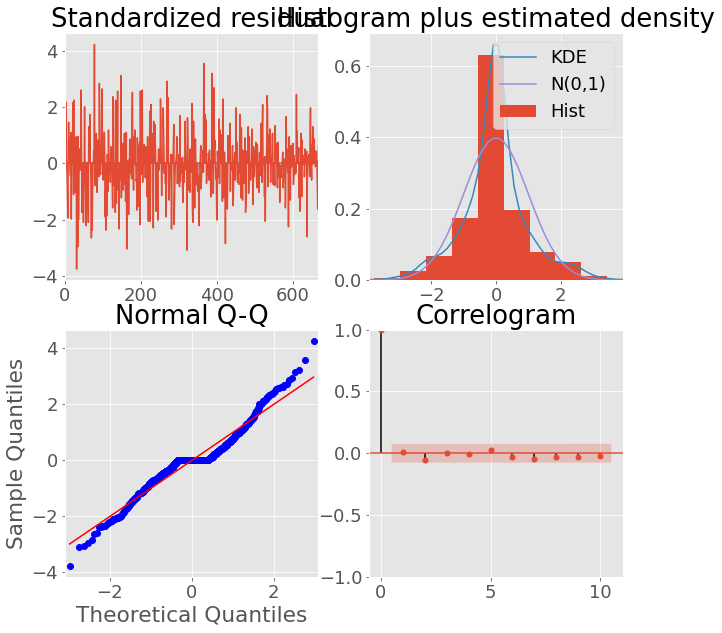

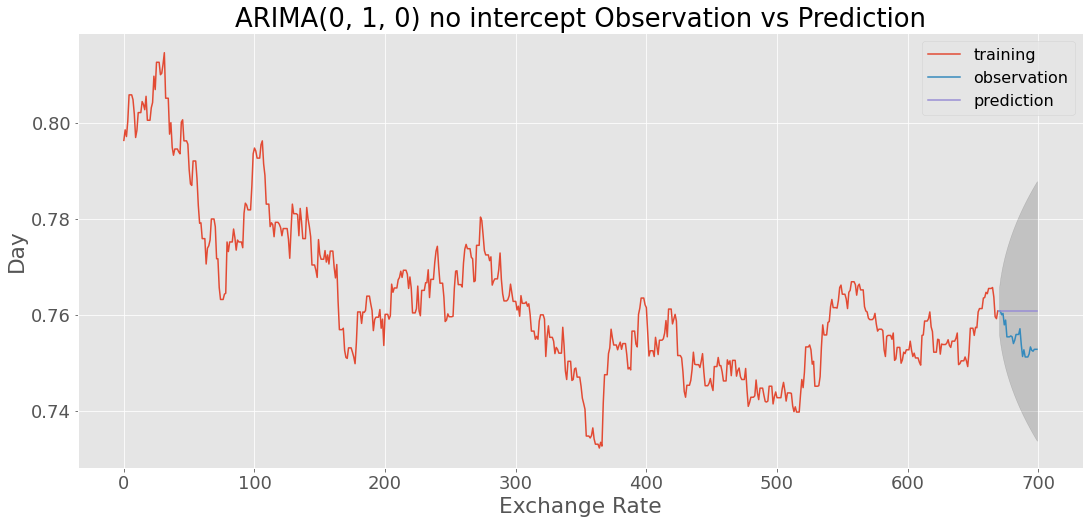

In [14]:
model_3 = pmdarima.auto_arima(
    train["close"],
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=1,
    d=None,
    seasonal=False,
    start_P=0,
    D=None,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(model_3.summary())
fc_series, lower_series, upper_series = arima_predict(
    model_3, valid.size, valid.index, auto=True
)
plot_forecast(
    train, valid, fc_series, "ARIMA(0, 1, 0) no intercept", lower_series, upper_series
)
scores_3 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(0, 1, 0) no intercept")

#### 1.3 Auto SARIMA Forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=-5892.089, BIC=-5869.605, Time=2.595 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=-4794.387, BIC=-4785.393, Time=0.101 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=-5809.097, BIC=-5791.109, Time=0.956 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=-5070.587, BIC=-5052.600, Time=2.047 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=-4793.774, BIC=-4789.278, Time=0.074 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=-5612.578, BIC=-5594.591, Time=0.322 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=-5838.679, BIC=-5811.699, Time=1.059 seconds
Fit ARIMA(1,0,1)x(0,1,2,7) [intercept=True]; AIC=-5875.083, BIC=-5848.102, Time=4.072 seconds
Fit ARIMA(1,0,1)x(1,1,0,7) [intercept=True]; AIC=-5816.905, BIC=-5794.421, Time=2.091 seconds
Fit ARIMA(1,0,1)x(1,1,2,7) [intercept=True]; AIC=-5922.868, BIC=-5891.391, Time=3.718 seconds
Fit ARIMA(1,0,1)

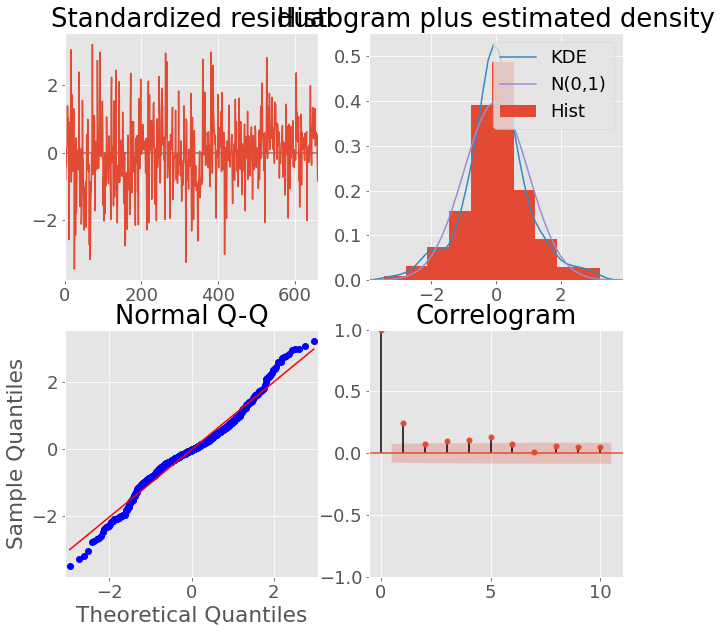

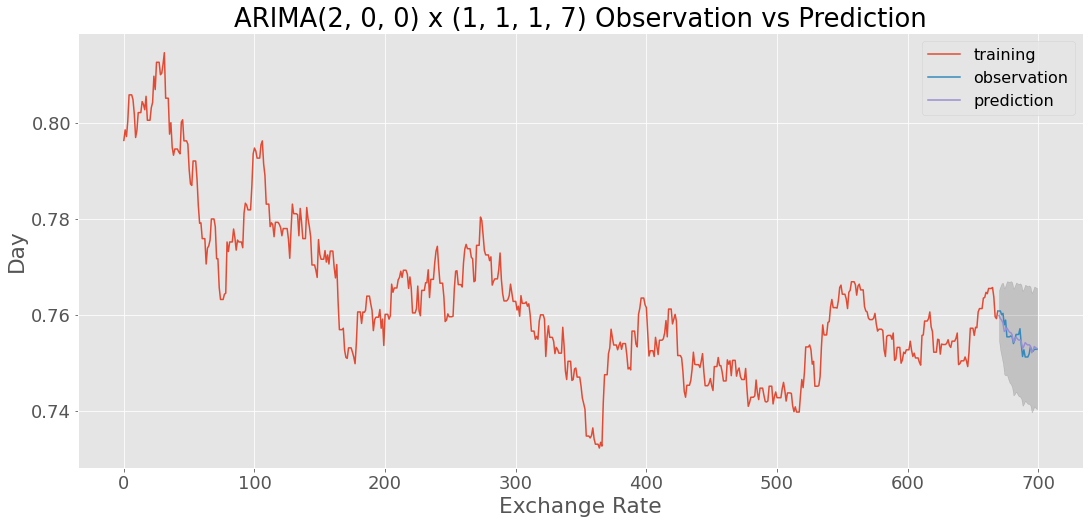

In [15]:
# Seasonal - fit stepwise auto-ARIMA
model_4 = pmdarima.auto_arima(
    train["close"],
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=7,
    start_P=0,
    seasonal=True,
    d=None,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

model_4.summary()
fc_series, lower_series, upper_series = arima_predict(
    model_4, valid.size, valid.index, auto=True
)
plot_forecast(
    train, valid, fc_series, "ARIMA(2, 0, 0) x (1, 1, 1, 7)", lower_series, upper_series
)
scores_4 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(2, 0, 0) x (0, 1, 1, 7)")

In [16]:
pd.concat(
    [scores_1, scores_2, scores_3, scores_4,]
)

,MAPE,RMSE,Min-Max Error
"ARIMA(1, 1, 1)",0.006652,0.005612,0.006597
"ARIMA(2, 0, 0)",0.008890,0.007476,0.008792
"ARIMA(0, 1, 0) no intercept",0.007728,0.006517,0.007654
"ARIMA(2, 0, 0) x (0, 1, 1, 7)",0.001544,0.001429,0.001542


Based on the evaluation scores, ARIMA(1, 0, 0) x (1, 1, 1, 7) is the best ARIMA model.

### 2. Classic supervised learning

#### Data transformation

The process is not stationary. A stationary time series has constant mean and variance. I'll remove the trend with differencing to stabilize the mean and use log or Box-Cox transformation to stabilize the variance.

In [17]:
# decide the order of differencing
ndiffs(train)

1

Set the number of differencing to 1.

#### log transformation

In [18]:
log_train = np.log(train).diff().dropna()

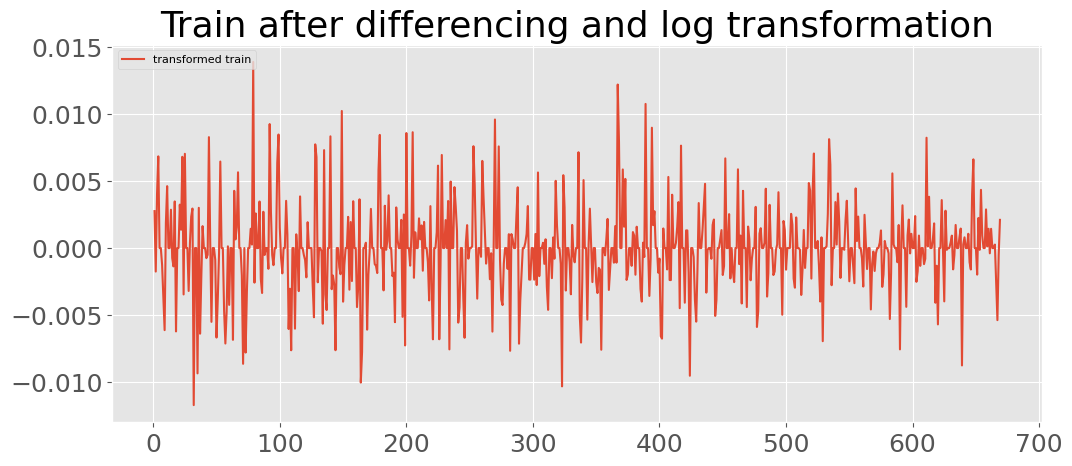

In [19]:
plot_trans_train(log_train, "log")

#### Box-Cox transformation

In [20]:
pre_boxcox_train, lamb = stats.boxcox(train.close)
boxcox_train = pd.DataFrame({"close": pre_boxcox_train}).diff().dropna()
lamb

-16.01142953164715

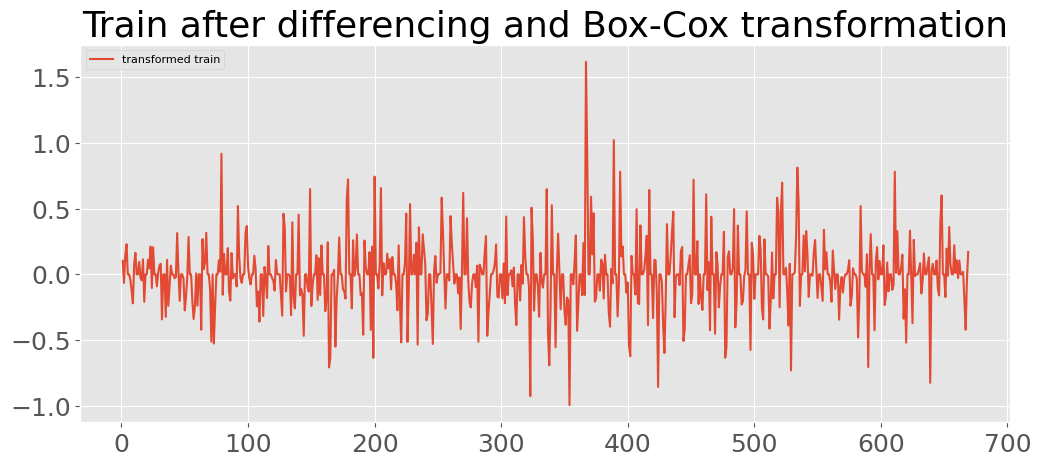

In [21]:
plot_trans_train(boxcox_train, "Box-Cox")

#### 2.1 Random Forests

**Random Forests (log transformation)**

Decide the hyperparameters, `n_estimators` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the RandomForestRegressor regressor ...
     cv_mean  cv_std
lag                 
11    -0.003   0.001
12    -0.003   0.001
19    -0.003   0.001
18    -0.003   0.001
17    -0.003   0.001
The best hyperparameters when lag = 11:
{'n_estimators': 100}


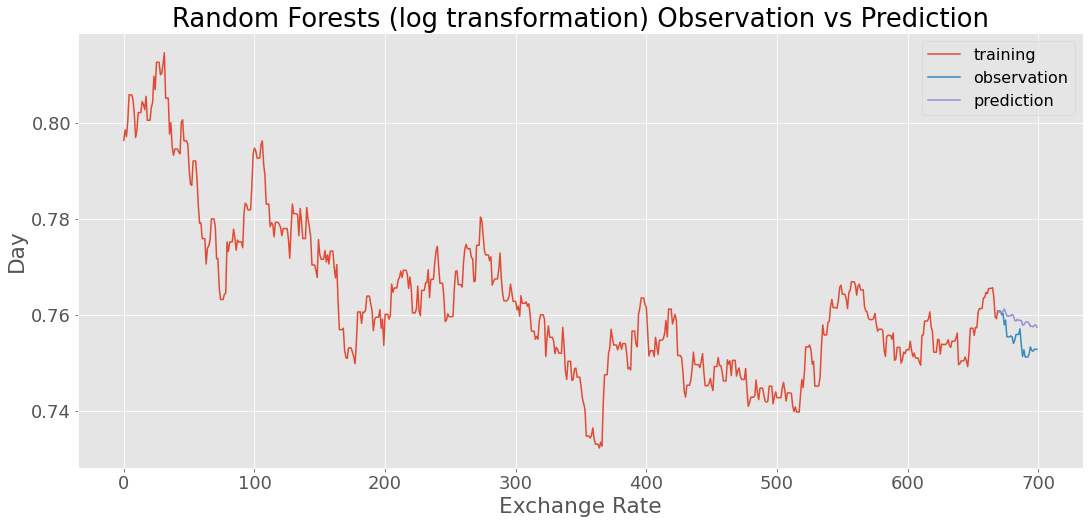

In [22]:
param_grid = {"n_estimators": [10, 50, 100, 150]}
model_5, scores_5 = analyze_regressor(
    "RandomForestRegressor",
    "Random Forests (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)


**Random Forests (Box-Cox transformation)**

Decide the hyperparameters, `n_estimators` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the RandomForestRegressor regressor ...
     cv_mean  cv_std
lag                 
12    -0.277   0.046
11    -0.278   0.051
8     -0.278   0.051
9     -0.279   0.052
10    -0.279   0.049
The best hyperparameters when lag = 12:
{'n_estimators': 100}


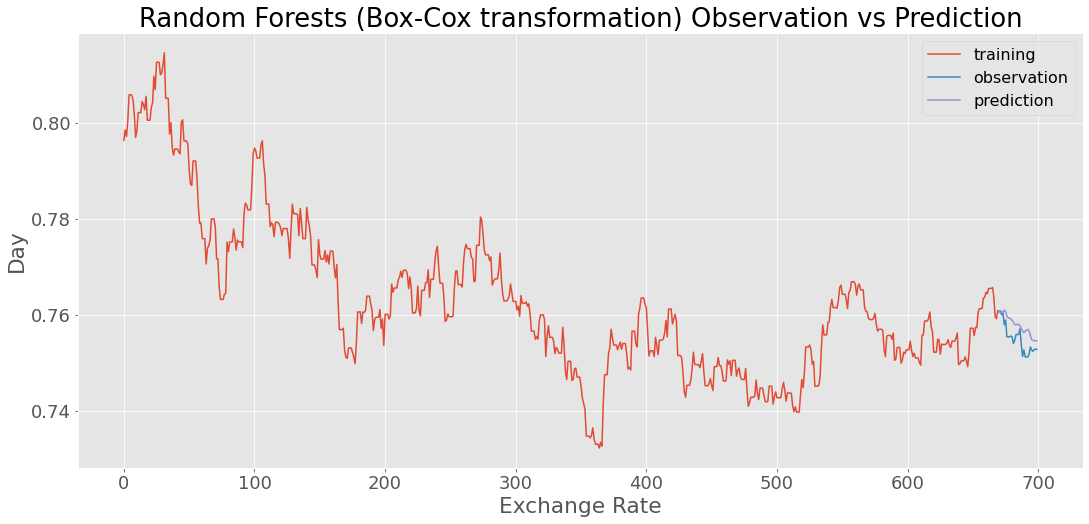

In [23]:
param_grid = {"n_estimators": [10, 50, 100, 150]}
model_6, scores_6 = analyze_regressor(
    "RandomForestRegressor",
    "Random Forests (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)

In [24]:
pd.concat([scores_5, scores_6])

,MAPE,RMSE,Min-Max Error
Random Forests (log transformation),0.005439,0.004578,0.005402
Random Forests (Box-Cox transformation),0.003805,0.003289,0.003786


The Random Forests (Box-Cox transformation) model gives the best scores.

#### 2.2 k-nearest neighbors


**k-nearest neighbors (log transformation)**

Decide the hyperparameters, `n_neighbors` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the KNeighborsRegressor regressor ...
     cv_mean  cv_std
lag                 
16    -0.003   0.001
7     -0.003   0.001
8     -0.003   0.001
9     -0.003   0.000
1     -0.004   0.001
The best hyperparameters when lag = 16:
{'n_neighbors': 19}


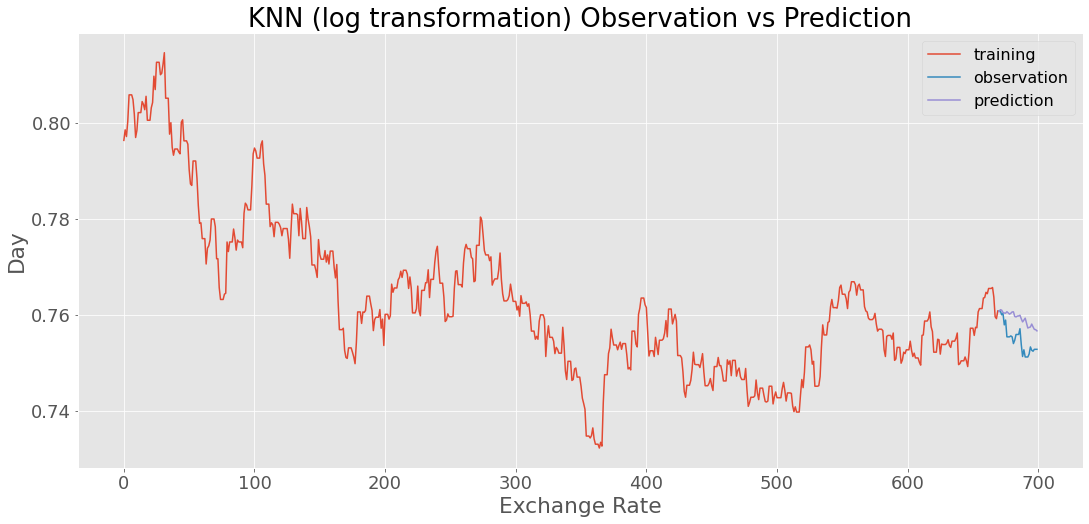

In [25]:
param_grid = {"n_neighbors": list(range(1, 20))}
model_7, scores_7 = analyze_regressor(
    "KNeighborsRegressor",
    "KNN (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)


**k-nearest neighbors (Box-Cox transformation)**

Decide the hyperparameters, `n_neighbors` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the KNeighborsRegressor regressor ...
     cv_mean  cv_std
lag                 
7     -0.276   0.054
14    -0.277   0.049
8     -0.279   0.049
9     -0.281   0.052
13    -0.281   0.049
The best hyperparameters when lag = 7:
{'n_neighbors': 14}


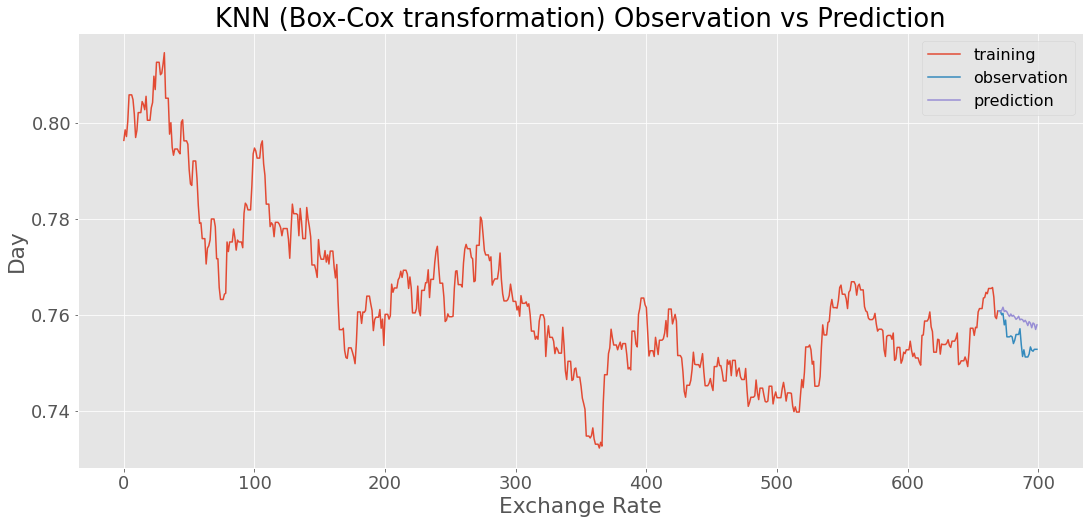

In [26]:
param_grid = {"n_neighbors": list(range(1, 20))}
model_8, scores_8 = analyze_regressor(
    "KNeighborsRegressor",
    "KNN (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)

In [27]:
pd.concat([scores_7, scores_8])

,MAPE,RMSE,Min-Max Error
KNN (log transformation),0.005685,0.004753,0.005646
KNN (Box-Cox transformation),0.005756,0.004798,0.005716


The KNN (log transformation) model gives the best scores.

#### 2.3 Gradient Boosting Regressor


**Gradient Boosting Regressor (log transformation)**

Decide the hyperparameters, `n_estimators`, `learning_rate` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the GradientBoostingRegressor regressor ...
     cv_mean  cv_std
lag                 
11    -0.003   0.001
12    -0.003   0.001
19    -0.003   0.001
18    -0.003   0.001
17    -0.003   0.001
The best hyperparameters when lag = 11:
{'learning_rate': 0.001, 'n_estimators': 50}


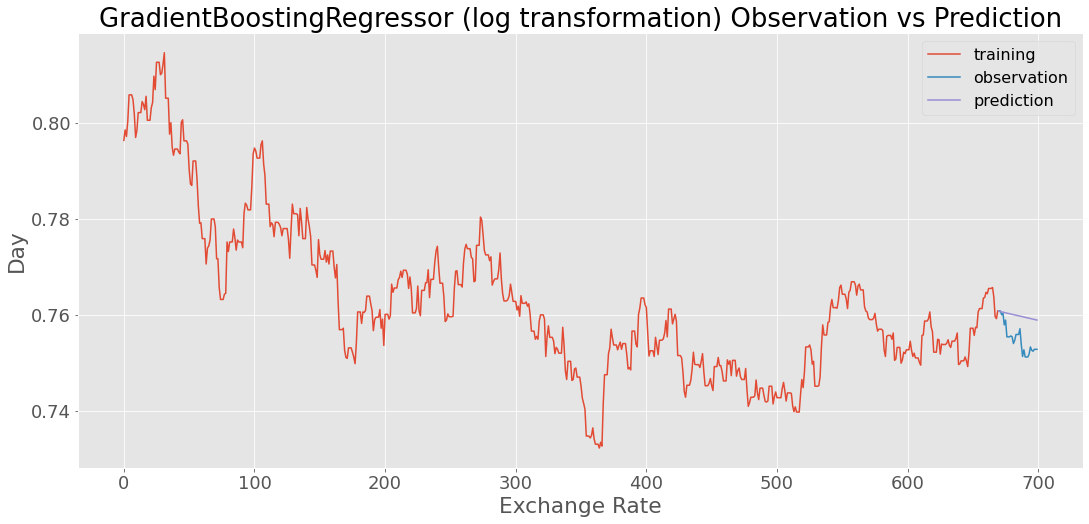

In [28]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_9, scores_9 = analyze_regressor(
    "GradientBoostingRegressor",
    "GradientBoostingRegressor (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)


**Gradient Boosting Regressor (Box-Cox transformation)**

Decide the hyperparameters, `n_neighbors` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the GradientBoostingRegressor regressor ...
     cv_mean  cv_std
lag                 
1     -0.291   0.051
12    -0.291   0.058
2     -0.291   0.046
4     -0.293   0.058
5     -0.293   0.057
The best hyperparameters when lag = 1:
{'learning_rate': 0.001, 'n_estimators': 50}


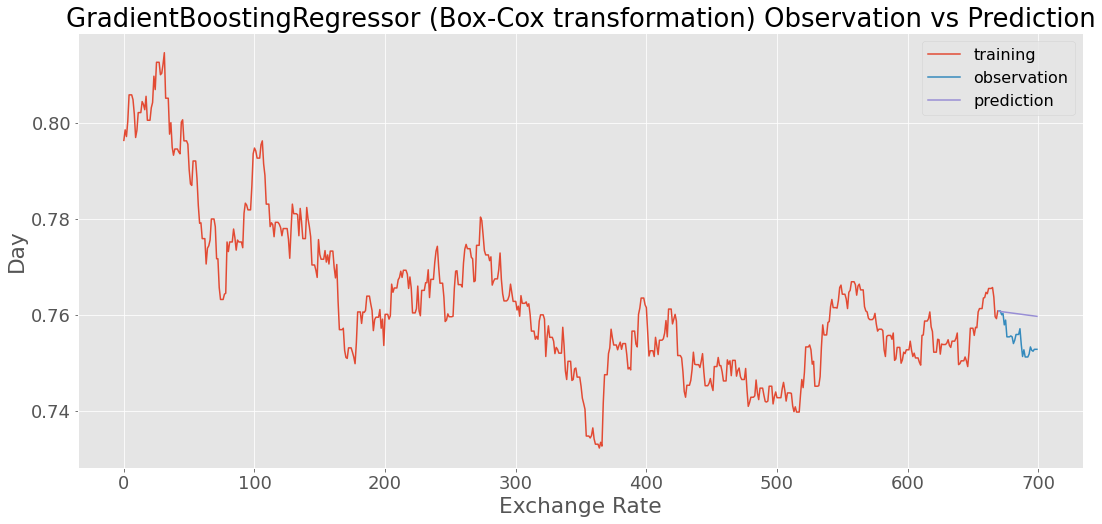

In [29]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_10, scores_10 = analyze_regressor(
    "GradientBoostingRegressor",
    "GradientBoostingRegressor (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)

In [30]:
pd.concat([scores_9, scores_10])

,MAPE,RMSE,Min-Max Error
GradientBoostingRegressor (log transformation),0.006446,0.005440,0.006394
GradientBoostingRegressor (Box-Cox transformation),0.006954,0.005868,0.006894


The GradientBoostingRegressor  (log transformation) model gives the best scores.

#### 2.3 Light GBM Regressor


**Light GBM Regressor (log transformation)**

Decide the hyperparameters, `n_estimators`, `learning_rate` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the LGBMRegressor regressor ...
     cv_mean  cv_std
lag                 
1     -0.003   0.001
3     -0.003   0.001
2     -0.003   0.001
12    -0.004   0.000
19    -0.004   0.001
The best hyperparameters when lag = 1:
{'learning_rate': 0.001, 'n_estimators': 50}


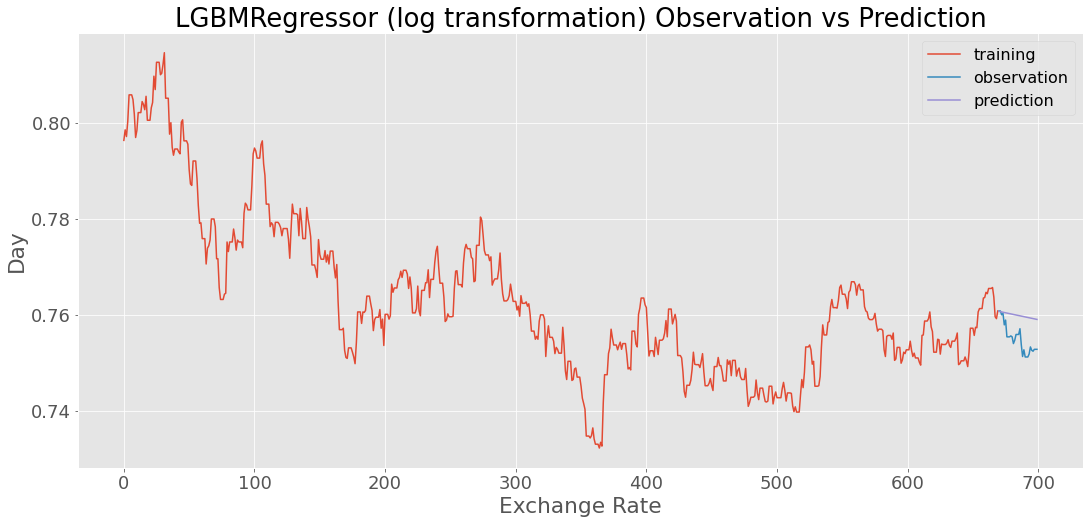

In [31]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_11, scores_11 = analyze_regressor(
    "LGBMRegressor",
    "LGBMRegressor (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)


**Light GBM Regressor (Box-Cox transformation)**

Decide the hyperparameters, `n_estimators`, `learning_rate` and `lag`, with cross-validation


Performing cross-validation to optimzie the lag and hyperparameters for the LGBMRegressor regressor ...
     cv_mean  cv_std
lag                 
1     -0.279   0.043
9     -0.281   0.053
2     -0.282   0.044
8     -0.282   0.052
7     -0.284   0.051
The best hyperparameters when lag = 1:
{'learning_rate': 0.001, 'n_estimators': 50}


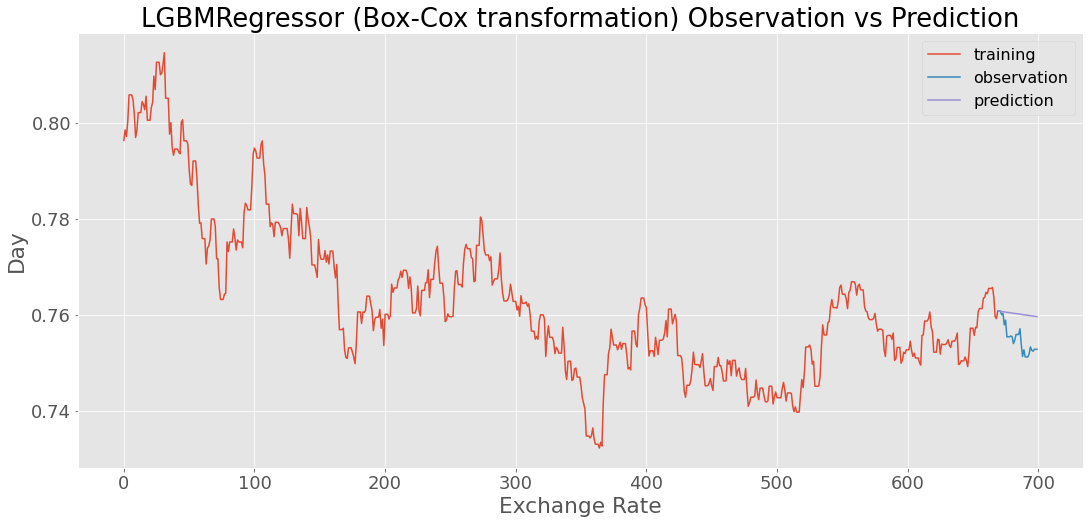

In [32]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_12, scores_12 = analyze_regressor(
    "LGBMRegressor",
    "LGBMRegressor (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)

In [33]:
pd.concat([scores_11, scores_12])

,MAPE,RMSE,Min-Max Error
LGBMRegressor (log transformation),0.006523,0.005506,0.006470
LGBMRegressor (Box-Cox transformation),0.006926,0.005841,0.006866


The LGBMRegressor  (log transformation) model gives the best scores.


In [34]:
pd.concat([scores_6, scores_7, scores_9, scores_11])

,MAPE,RMSE,Min-Max Error
Random Forests (Box-Cox transformation),0.003805,0.003289,0.003786
KNN (log transformation),0.005685,0.004753,0.005646
GradientBoostingRegressor (log transformation),0.006446,0.005440,0.006394
LGBMRegressor (log transformation),0.006523,0.005506,0.006470


The KNN (Box-Cox transformation) model gives the best scores.

### 3. LSTM Recurrent Neural Networks



In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = cad_to_usd[["close"]].copy()
scaled_df["close"] = scaler.fit_transform(cad_to_usd[["close"]])
train, valid, test, train_valid = split_data(scaled_df)
response_col = ["close"]

In [36]:
start = time()
lstm_cv_scores = lstm_cross_validation(train_valid, response_col, scaler)
print(f"\Training took: {hms_string(time()-start)}")

  0%|          | 0/20 [00:00<?, ?it/s]

lag = 1


  5%|▌         | 1/20 [04:01<1:16:34, 241.81s/it]

lag = 2


 10%|█         | 2/20 [08:06<1:12:46, 242.56s/it]

lag = 3


 15%|█▌        | 3/20 [12:09<1:08:45, 242.69s/it]

lag = 4


 20%|██        | 4/20 [16:10<1:04:36, 242.30s/it]

lag = 5


 25%|██▌       | 5/20 [20:13<1:00:39, 242.65s/it]

lag = 6


 30%|███       | 6/20 [24:16<56:35, 242.57s/it]  

lag = 7


 35%|███▌      | 7/20 [28:18<52:33, 242.59s/it]

lag = 8


 40%|████      | 8/20 [32:19<48:23, 241.95s/it]

lag = 9


 45%|████▌     | 9/20 [36:20<44:19, 241.81s/it]

lag = 10


 50%|█████     | 10/20 [40:20<40:11, 241.20s/it]

lag = 11


 55%|█████▌    | 11/20 [44:20<36:05, 240.66s/it]

lag = 12


 60%|██████    | 12/20 [48:22<32:09, 241.13s/it]

lag = 13


 65%|██████▌   | 13/20 [52:22<28:05, 240.82s/it]

lag = 14


 70%|███████   | 14/20 [56:21<24:02, 240.34s/it]

lag = 15


 75%|███████▌  | 15/20 [1:00:19<19:58, 239.62s/it]

lag = 16


 80%|████████  | 16/20 [1:04:15<15:54, 238.62s/it]

lag = 17


 85%|████████▌ | 17/20 [1:08:17<11:58, 239.66s/it]

lag = 18


 90%|█████████ | 18/20 [1:12:16<07:58, 239.19s/it]

lag = 19


 95%|█████████▌| 19/20 [1:16:13<03:58, 238.79s/it]

lag = 20


100%|██████████| 20/20 [1:20:12<00:00, 240.60s/it]

\Training took: 1:20:12.10


In [37]:
lstm_cv_scores

,cv_mean,cv_std
lag,,
16,0.010,0.002
1,0.012,0.006
11,0.012,0.005
...,...,...
17,0.014,0.007
6,0.018,0.012
13,0.018,0.006


lag = 16
Epoch 1/30
 - 3s - loss: 0.0093
Epoch 2/30
 - 3s - loss: 0.0027
Epoch 3/30
 - 3s - loss: 0.0021
Epoch 4/30
 - 3s - loss: 0.0019
Epoch 5/30
 - 3s - loss: 0.0018
Epoch 6/30
 - 3s - loss: 0.0018
Epoch 7/30
 - 3s - loss: 0.0015
Epoch 8/30
 - 3s - loss: 0.0015
Epoch 9/30
 - 3s - loss: 0.0015
Epoch 10/30
 - 3s - loss: 0.0013
Epoch 11/30
 - 3s - loss: 0.0014
Epoch 12/30
 - 3s - loss: 0.0015
Epoch 13/30
 - 3s - loss: 0.0013
Epoch 14/30
 - 3s - loss: 0.0014
Epoch 15/30
 - 3s - loss: 0.0013
Epoch 16/30
 - 3s - loss: 0.0013
Epoch 17/30
 - 3s - loss: 0.0013
Epoch 18/30
 - 3s - loss: 0.0012
Epoch 19/30
 - 3s - loss: 0.0013
Epoch 20/30
 - 3s - loss: 0.0013
Epoch 21/30
 - 3s - loss: 0.0013
Epoch 22/30
 - 3s - loss: 0.0012
Epoch 23/30
 - 3s - loss: 0.0012
Epoch 24/30
 - 3s - loss: 0.0012
Epoch 25/30
 - 3s - loss: 0.0012
Epoch 26/30
 - 3s - loss: 0.0012
Epoch 27/30
 - 3s - loss: 0.0012
Epoch 28/30
 - 3s - loss: 0.0012
Epoch 29/30
 - 3s - loss: 0.0013
Epoch 30/30
 - 3s - loss: 0.0013


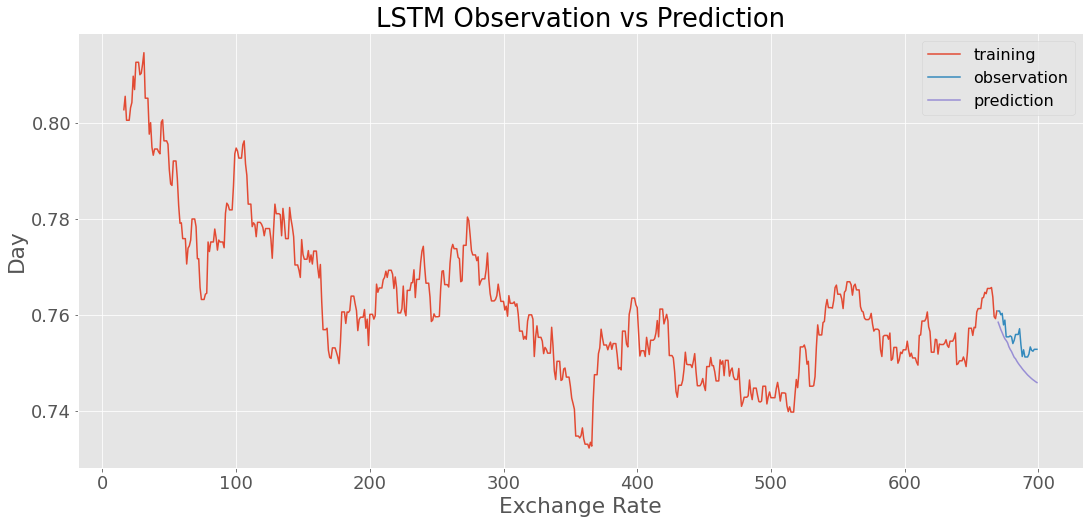

In [38]:
lag = lstm_cv_scores.index[0]
print(f'lag = {lag}')
df_lag = lag_df(scaled_df, lag, response_col).dropna()
train, valid, test, train_valid = split_data(df_lag)
model_13, scores_13 = lstm_results(train, valid, lag, response_col, scaler, 'LSTM')

In [39]:
scores_13

,MAPE,RMSE,Min-Max Error
LSTM,0.005464,0.004491,0.005464


In [40]:
pd.concat([scores_4, scores_6, scores_13])

,MAPE,RMSE,Min-Max Error
"ARIMA(2, 0, 0) x (0, 1, 1, 7)",0.001544,0.001429,0.001542
Random Forests (Box-Cox transformation),0.003805,0.003289,0.003786
LSTM,0.005464,0.004491,0.005464


LSTM model gives the best scores

### 4. Final Model



/home/ubuntu/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                  700
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 7)   Log Likelihood                3125.732
Date:                             Mon, 29 Jun 2020   AIC                          -6243.464
Time:                                     04:01:15   BIC                          -6225.300
Sample:                                          0   HQIC                         -6236.439
                                             - 700                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9219      0.039     23.509      0.000       0.845       0.999
ar.L2         -0.0315      

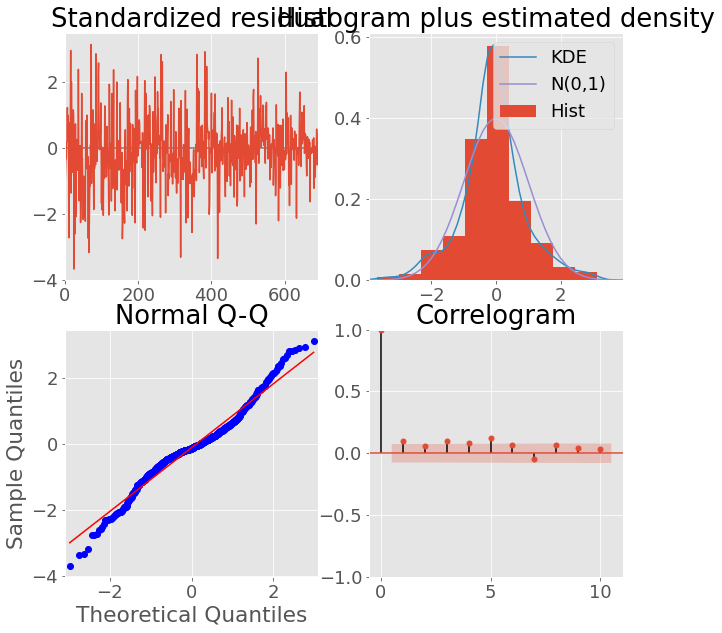

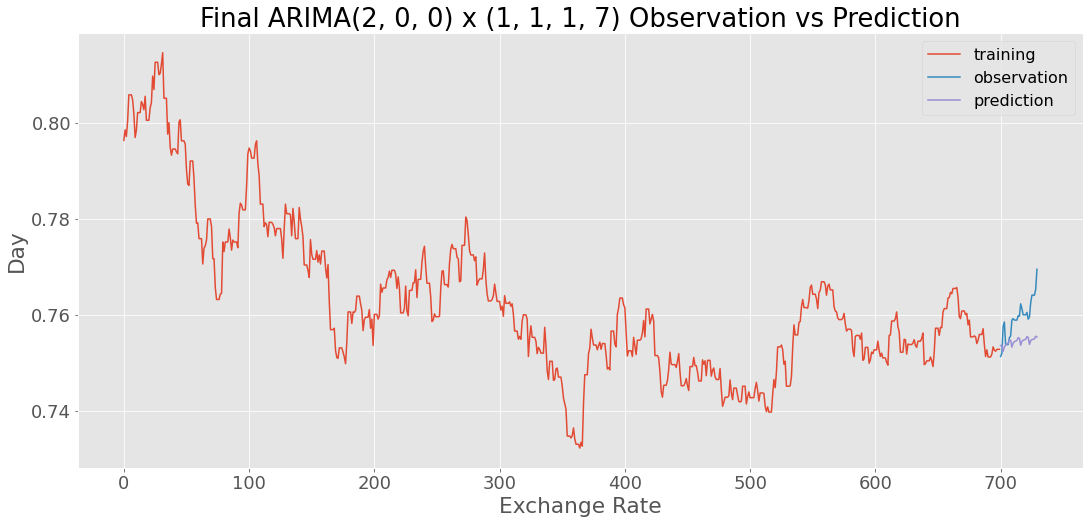

In [41]:
train, valid, test, train_valid = split_data(cad_to_usd[["close"]], 30)
final_1 = sm.tsa.statespace.SARIMAX(train_valid["close"], order=(2, 0, 0), seasonal_order=(0, 1, 1, 7))
final_1 = final_1.fit(disp=False)
print(final_1.summary())
fc_series, lower_series, upper_series = arima_predict(
    final_1, test.size, test.index, auto=True
)
plot_forecast(
    train_valid, test, fc_series, "Final ARIMA(2, 0, 0) x (1, 1, 1, 7)", lower_series, upper_series
)
final_scores_1 = evaluate_model(fc_series, test.squeeze(), "ARIMA(2, 0, 0) x (0, 1, 1, 7)")

-16.99340988651612
Performing cross-validation to optimzie the lag and hyperparameters for the RandomForestRegressor regressor ...
     cv_mean  cv_std
lag                 
12    -0.357   0.080
17    -0.357   0.083
20    -0.360   0.081
16    -0.360   0.086
15    -0.360   0.093
The best hyperparameters when lag = 12:
{'n_estimators': 100}


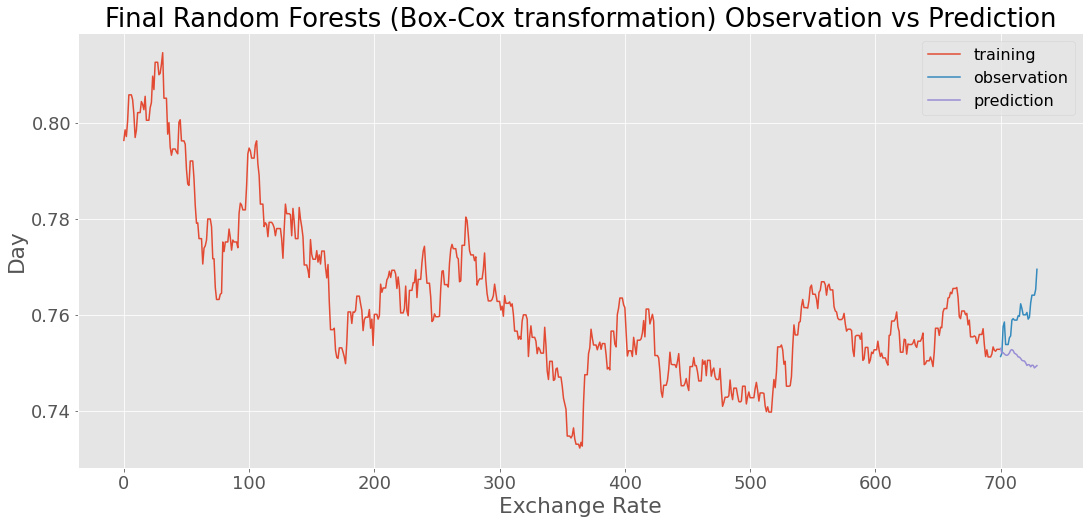

In [42]:
train, valid, test, train_valid = split_data(cad_to_usd[["close"]], 30)
pre_boxcox_train_valid, lamb = stats.boxcox(train_valid.close)
boxcox_train_valid = pd.DataFrame({"close": pre_boxcox_train_valid}).diff().dropna()
print(lamb)
param_grid = {"n_estimators": [10, 50, 100, 150]}
final_2, final_scores_2 = analyze_regressor(
    "RandomForestRegressor",
    "Final Random Forests (Box-Cox transformation)",
    train_valid,
    test,
    8,
    ["close"],
    boxcox_train_valid,
    param_grid,
    test.index,
    pre_boxcox_train_valid[-1],
    log=False,
    lamb=lamb,
)

lag = 16
Epoch 1/30
 - 3s - loss: 0.0043
Epoch 2/30
 - 3s - loss: 0.0024
Epoch 3/30
 - 3s - loss: 0.0019
Epoch 4/30
 - 3s - loss: 0.0017
Epoch 5/30
 - 3s - loss: 0.0017
Epoch 6/30
 - 3s - loss: 0.0016
Epoch 7/30
 - 3s - loss: 0.0015
Epoch 8/30
 - 3s - loss: 0.0014
Epoch 9/30
 - 3s - loss: 0.0013
Epoch 10/30
 - 3s - loss: 0.0013
Epoch 11/30
 - 3s - loss: 0.0013
Epoch 12/30
 - 3s - loss: 0.0014
Epoch 13/30
 - 3s - loss: 0.0013
Epoch 14/30
 - 3s - loss: 0.0013
Epoch 15/30
 - 3s - loss: 0.0013
Epoch 16/30
 - 3s - loss: 0.0013
Epoch 17/30
 - 3s - loss: 0.0012
Epoch 18/30
 - 3s - loss: 0.0012
Epoch 19/30
 - 3s - loss: 0.0012
Epoch 20/30
 - 3s - loss: 0.0012
Epoch 21/30
 - 3s - loss: 0.0012
Epoch 22/30
 - 3s - loss: 0.0012
Epoch 23/30
 - 3s - loss: 0.0012
Epoch 24/30
 - 3s - loss: 0.0012
Epoch 25/30
 - 3s - loss: 0.0012
Epoch 26/30
 - 3s - loss: 0.0012
Epoch 27/30
 - 3s - loss: 0.0012
Epoch 28/30
 - 3s - loss: 0.0012
Epoch 29/30
 - 3s - loss: 0.0012
Epoch 30/30
 - 3s - loss: 0.0012


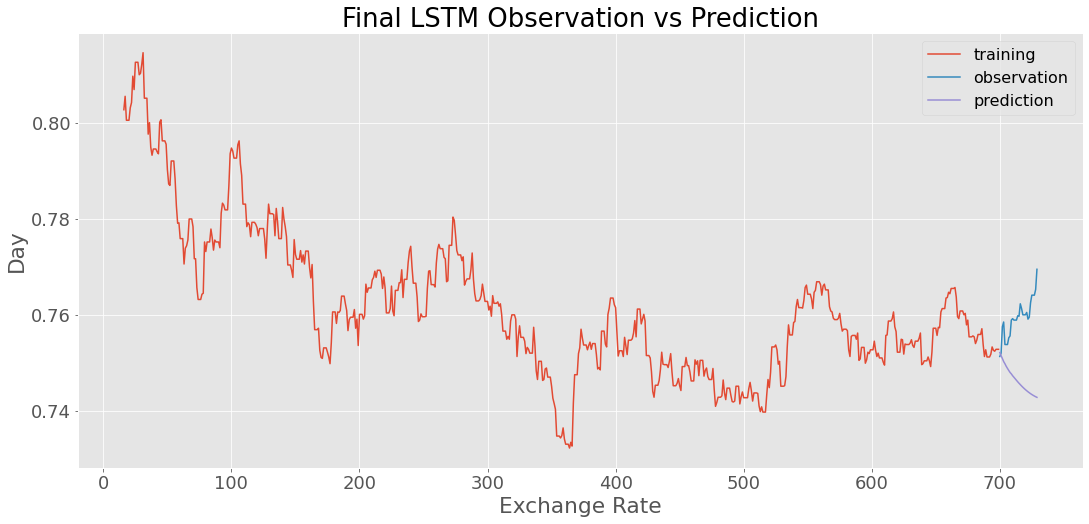

In [43]:
lag = lstm_cv_scores.index[0]
print(f'lag = {lag}')
df_lag = lag_df(scaled_df, lag, response_col).dropna()
train, valid, test, train_valid = split_data(df_lag)
final_3, final_scores_3 = lstm_results(train_valid, test, lag, response_col, scaler, 'Final LSTM')

In [44]:
pd.concat([final_scores_1, final_scores_2, final_scores_3])

,MAPE,RMSE,Min-Max Error
"ARIMA(2, 0, 0) x (0, 1, 1, 7)",0.006749,0.006071,0.006748
Final Random Forests (Box-Cox transformation),0.011104,0.009718,0.011103
Final LSTM,0.017033,0.014452,0.017033


In [45]:
pd.concat([final_scores_1, final_scores_2, final_scores_3]).to_csv('../results/final.csv')

## 8. Summary and conclusions
